In [1]:
import pandas as pd
import numpy as np
import json
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,ElasticNet,Lasso,Ridge
from visualization_utils import *
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import SplineTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
TRAIN_MODELS = False
results = []

In [3]:
import pandas as pd
from typing import Dict, Optional

# --- Mapping dictionaries (same categories we discussed) ---
brand_price_tier: Dict[str, str] = {
    "audi": "premium", "porsche": "luxury", "bmw": "luxury", "dodge": "mainstream",
    "dongfeng": "value", "ford": "mainstream", "honda": "mainstream", "hyundai": "mainstream",
    "land": "premium", "lexus": "premium", "maserati": "luxury", "mercedes-benz": "luxury",
    "skoda": "mainstream", "subaru": "mainstream", "toyota": "mainstream", "vw": "mainstream",
    "volvo": "premium", "alfa": "premium", "cupra": "upper_mid", "ds": "upper_mid",
    "haval": "value", "jeep": "upper_mid", "kia": "mainstream", "mazda": "mainstream",
    "mini": "premium", "peugeot": "mainstream", "mitsubishi": "mainstream", "nissan": "mainstream",
    "seat": "mainstream", "ssangyong": "value", "tesla": "premium", "acura": "premium",
    "alpina": "premium", "aston": "ultra_luxury", "bentley": "ultra_luxury", "byd": "value",
    "cadillac": "premium", "chevrolet": "mainstream", "chrysler": "mainstream", "citroen": "mainstream",
    "fiat": "mainstream", "foton": "value", "geely": "value", "genesis": "premium", "gmc": "premium",
    "great": "value", "jaguar": "premium", "infiniti": "premium", "lincoln": "premium",
    "lynkco": "upper_mid", "mg": "value", "opel": "mainstream", "renault": "mainstream",
    "smart": "niche", "voyah": "value", "dacia": "budget", "lada": "budget", "pontiac": "defunct",
    "suzuki": "mainstream", "daihatsu": "value", "gaz": "value", "isuzu": "value", "lancia": "niche",
    "mahindra": "value", "saab": "defunct", "daewoo": "defunct", "moskvich": "defunct",
    "trabant": "defunct", "triumph": "defunct", "uaz": "value", "wartburg": "defunct",
    "lamborghini": "ultra_luxury", "ferrari": "ultra_luxury", "maybach": "ultra_luxury",
    "baic": "value", "ineos": "niche", "morgan": "niche", "polestar": "premium", "tata": "value",
    "volga": "defunct", "abarth": "upper_mid", "hummer": "niche", "iveco": "value",
    "mclaren": "ultra_luxury", "rolls-royce": "ultra_luxury", "dkw": "defunct", "lotus": "niche",
    "secma": "niche", "други": "unknown", "baw": "value", "carbodies": "niche", "rover": "defunct",
    "talbot": "defunct", "daimler": "niche", "dr": "niche", "oldsmobile": "defunct", "buick": "premium",
    "gwm": "value", "swm": "value", "shuanghuan": "value", "changan": "value", "leapmotor": "value",
    "dfsk": "value", "чайка": "defunct", "austin": "defunct", "tempo": "defunct", "zaz": "defunct",
    "seres": "value", "maxus": "value", "microcar": "niche", "aixam": "niche", "chery": "value",
    "fisker": "niche", "jac": "value", "landwind": "value", "eagle": "defunct", "goupil": "niche",
    "brilliance": "value", "plymouth": "defunct", "asia": "unknown", "gonow": "value", "simca": "defunct",
    "wey": "upper_mid", "hongqi": "upper_mid"
}

brand_region: Dict[str, str] = {
    "audi": "europe", "porsche": "europe", "bmw": "europe", "dodge": "north_america", "dongfeng": "china",
    "ford": "north_america", "honda": "asia", "hyundai": "south_korea", "land": "uk", "lexus": "asia",
    "maserati": "europe", "mercedes-benz": "europe", "skoda": "europe", "subaru": "asia",
    "toyota": "asia", "vw": "europe", "volvo": "europe", "alfa": "europe", "cupra": "europe",
    "ds": "europe", "haval": "china", "jeep": "north_america", "kia": "south_korea", "mazda": "asia",
    "mini": "uk", "peugeot": "europe", "mitsubishi": "asia", "nissan": "asia", "seat": "europe",
    "ssangyong": "south_korea", "tesla": "north_america", "acura": "asia", "alpina": "europe",
    "aston": "uk", "bentley": "uk", "byd": "china", "cadillac": "north_america", "chevrolet": "north_america",
    "chrysler": "north_america", "citroen": "europe", "fiat": "europe", "foton": "china", "geely": "china",
    "genesis": "south_korea", "gmc": "north_america", "great": "china", "jaguar": "uk", "infiniti": "asia",
    "lincoln": "north_america", "lynkco": "china", "mg": "china", "opel": "europe", "renault": "europe",
    "smart": "europe", "voyah": "china", "dacia": "europe", "lada": "russia", "pontiac": "north_america",
    "suzuki": "asia", "daihatsu": "asia", "gaz": "russia", "isuzu": "asia", "lancia": "europe",
    "mahindra": "india", "saab": "europe", "daewoo": "asia", "moskvich": "russia", "trabant": "europe",
    "triumph": "uk", "uaz": "russia", "wartburg": "europe", "lamborghini": "europe", "ferrari": "europe",
    "maybach": "europe", "baic": "china", "ineos": "europe", "morgan": "uk", "polestar": "europe",
    "tata": "india", "volga": "russia", "abarth": "europe", "hummer": "north_america", "iveco": "europe",
    "mclaren": "uk", "rolls-royce": "uk", "dkw": "europe", "lotus": "uk", "secma": "europe", "други": "unknown",
    "baw": "china", "carbodies": "uk", "rover": "uk", "talbot": "europe", "daimler": "europe", "dr": "europe",
    "oldsmobile": "north_america", "buick": "north_america", "gwm": "china", "swm": "china", "shuanghuan": "china",
    "changan": "china", "leapmotor": "china", "dfsk": "china", "чайка": "russia", "austin": "uk", "tempo": "europe",
    "zaz": "europe", "seres": "china", "maxus": "china", "microcar": "europe", "aixam": "europe", "chery": "china",
    "fisker": "north_america", "jac": "china", "landwind": "china", "eagle": "north_america", "goupil": "europe",
    "brilliance": "china", "plymouth": "north_america", "asia": "unknown", "gonow": "china", "simca": "europe",
    "wey": "china", "hongqi": "china"
}

brand_ev_focus: Dict[str, str] = {
    "tesla": "ev_leader", "byd": "ev_leader", "polestar": "ev_active", "fisker": "ev_active",
    "nissan": "ev_present", "bmw": "ev_present", "audi": "ev_present", "mercedes-benz": "ev_present",
    "vw": "ev_present", "hyundai": "ev_present", "kia": "ev_present", "volvo": "ev_present",
    "genesis": "ev_present", "leapmotor": "ev_active", "seres": "ev_active", "voyah": "ev_active",
    "great": "ev_present", "gwm": "ev_present", "geely": "ev_present", "changan": "ev_present",
    "honda": "low_ev", "toyota": "low_ev", "ford": "ev_present", "chevrolet": "ev_present",
    "renault": "ev_present", "smart": "ev_present", "porsche": "ev_present", "mini": "ev_present",
    # fallback for others will be handled in the function
}

brand_orientation: Dict[str, str] = {
    "ferrari": "sport", "lamborghini": "sport", "mclaren": "sport", "lotus": "sport",
    "porsche": "performance", "alpina": "performance", "dodge": "performance", "abarth": "performance",
    "jeep": "utility_commercial", "foton": "utility_commercial", "gmc": "utility_commercial", "iveco": "utility_commercial",
    "ford": "family", "toyota": "family", "honda": "family", "nissan": "family", "renault": "family",
    "mini": "compact_city", "smart": "compact_city", "aixam": "compact_city", "microcar": "compact_city",
    "rolls-royce": "luxury_grand_tourer", "bentley": "luxury_grand_tourer", "maybach": "luxury_grand_tourer",
    # unspecified brands will get default "general"
}

brand_status: Dict[str, str] = {
    "saab": "defunct", "pontiac": "defunct", "oldsmobile": "defunct", "plymouth": "defunct",
    "daewoo": "defunct", "dkw": "defunct", "trabant": "defunct", "wartburg": "defunct",
    "moskvich": "defunct", "rover": "defunct", "talbot": "defunct", "simca": "defunct",
    "eagle": "defunct", "austin": "defunct", "tempo": "defunct", "volga": "defunct",
    "други": "unknown", "asia": "unknown"
}
def map_with_default(series: pd.Series, mapping: Dict[str, str], default: str,is_categorical=True) -> pd.Series:
    mapped_series = series.map(lambda x: mapping.get(x, default))
    if is_categorical:
        return mapped_series.astype("category")
    else:
        return mapped_series
# --- Function to apply mappings ---
def apply_brand_mappings(
    df: pd.DataFrame,
    brand_col: str = "Brand",
    price_tier_map: Optional[Dict[str, str]] = None,
    region_map: Optional[Dict[str, str]] = None,
    ev_map: Optional[Dict[str, str]] = None,
    orientation_map: Optional[Dict[str, str]] = None,
    status_map: Optional[Dict[str, str]] = None,
) -> pd.DataFrame:

    # choose maps, prefer overrides
    price_map = price_tier_map or brand_price_tier
    region_map = region_map or brand_region
    ev_map = ev_map or brand_ev_focus
    orient_map = orientation_map or brand_orientation
    status_map = status_map or brand_status


    brand_series = df[brand_col]

    df["brand_price_tier"] = map_with_default(brand_series, price_map, "unknown")
    df["brand_region"] = map_with_default(brand_series, region_map, "unknown")
    df["brand_ev_focus"] = map_with_default(brand_series, ev_map, "unknown")
    df["brand_orientation"] = map_with_default(brand_series, orient_map, "general")
    df["brand_status"] = map_with_default(brand_series, status_map, "active")

    return df

def handle_description(df):
    with open('keywords.json',encoding='utf-8') as f:
        keywords=json.load(f)
    bad_tokens = keywords['bad_words'] 
    good_tokens = keywords['good_words']
    bad_re = re.compile(r"\b(" + "|".join(map(re.escape, bad_tokens)) + r")\b", flags=re.I)
    good_re = re.compile(r"\b(" + "|".join(map(re.escape, good_tokens)) + r")\b", flags=re.I)

    def count_matches(text, pattern):
        if not isinstance(text, str):
            return 0
        return len(pattern.findall(text))

    # предполагаме df.description съдържа описанията

    df["bad_count"] = df["CarDescription"].apply(lambda t: count_matches(t, bad_re))
    df["good_count"] = df["CarDescription"].apply(lambda t: count_matches(t, good_re))


In [4]:
def remove_outliers_from_numeric_columns(df,columns,drop=False,std_multiplier=3):
    for column in columns:
        if drop:
            df = df.drop(df[df[column] >= df[column].mean() + std_multiplier * df[column].std()].index)
            df = df.drop(df[df[column] <= df[column].mean() - std_multiplier * df[column].std()].index)
        else:
            df[column].loc[df[column] >= df[column].mean() + std_multiplier * df[column].std()] = np.nan
            df[column].loc[df[column] <= df[column].mean() - std_multiplier * df[column].std()] = np.nan
    return df

def plot_importance(model,num_features=50):
    feature_importance_df = pd.DataFrame({
        'feature':model.feature_names_in_,
        'importance':model.feature_importances_
    }).sort_values('importance',ascending=False)
    plt.figure(figsize=(16, 16), dpi=80)
    plt.title('Feature Importance Most Important')
    plt.barh(feature_importance_df['feature'][:num_features],feature_importance_df['importance'][:num_features])
    plt.figure(figsize=(16, 16), dpi=80)
    plt.title('Feature Importance Least Important')
    plt.xlim(right=0.01)
    plt.barh(feature_importance_df['feature'][-num_features:],feature_importance_df['importance'][-num_features:])

    feature_importance_df['InitialColumn'] = feature_importance_df['feature'].str.split('_').str[0]
    aggregated = feature_importance_df.groupby('InitialColumn')['importance'].sum().sort_values(ascending=False)
    plt.figure(figsize=(16, 16), dpi=80)
    plt.title('Aggregated Feature Importance by Initial Column')
    plt.barh(aggregated.index[:num_features],aggregated.values[:num_features])
    return feature_importance_df,aggregated

def sumarize_small_values_in_column(df,column,threshold=0.01):
    value_counts = df[column].value_counts(normalize=True)
    small_values = value_counts[value_counts < threshold].index
    df[column] = df[column].replace(small_values, 'Other')
    return df, small_values

def impute_missing_numerical_values(df, numerical_columns):
    for col in numerical_columns:
        median = df[col].median()
        df[col] = df[col].fillna(median)
    return df

def get_split_data(df, target_column,seed=42):
    y=df[target_column]
    X=df.drop(columns=[target_column])
    return train_test_split(X, y, test_size=0.3, random_state=seed,shuffle=True)

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test,train_model=True,is_log_transform=False,display_graphs=True):
    if train_model:
        model.fit(X_train, y_train)
    results_train = model.predict(X_train)
    results_test = model.predict(X_test)
    if is_log_transform:
        results_train = np.exp(results_train)
        results_test = np.exp(results_test)
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
    train_r2 = r2_score(y_train,results_train)
    test_r2 = r2_score(y_test,results_test)
    train_rmse = root_mean_squared_error(y_train,results_train)
    test_rmse = root_mean_squared_error(y_test,results_test)
    train_mae = mean_absolute_error(y_train,results_train)
    test_mae = mean_absolute_error(y_test,results_test)
    train_score_adj_r2 = 1 - (1 - train_r2) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)
    test_score_adj_r2 = 1 - (1 - test_r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    print(f"Train R2: {round(train_r2, 4)}")
    print(f"Train Adjusted R2: {round(train_score_adj_r2, 4)}")
    print(f"Train RMSE: {round(train_rmse, 4)}")
    print(f"Train MAE: {round(train_mae,4)}")
    print(f"Test R2: {round(test_r2, 4)}")
    print(f"Test Adjusted R2: {round(test_score_adj_r2, 4)}")
    print(f"Test RMSE: {round(test_rmse, 4)}")
    print(f"Test MAE: {round(test_mae,4)}")
    if display_graphs:
        sns.regplot(x=y_test, y=results_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.grid(True)
        plt.show()
        residuals = y_test-results_test
        sns.histplot(residuals,bins=100)
    return train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae

def add_features(df):
    CURRENT_YEAR = 2025

    df['KmPerYear'] = df['KmDriven'] / (CURRENT_YEAR - df['Year']).replace(0, 1)
    df['HighKmPerYearFlag'] = (df['KmPerYear'] > df['KmPerYear'].quantile(0.95))
    df['LowKmPerYearFlag'] = (df['KmPerYear'] < df['KmPerYear'].quantile(0.05))
    df['Hoursepower_per_km'] = (df['Horsepower'] / df['KmDriven'].replace(0, 1))
    df['HP_per_cc'] = df['Horsepower'] / df['CubicCapacity'].replace(0, np.nan)
    df['Hoursepower_per_age'] = df['Horsepower'] /  (CURRENT_YEAR - df['Year']).replace(0, 1)

    df['bm_median_km'] = df.groupby(['Brand','Model'])['KmDriven'].transform('median')

    df['Km_vs_bm_median'] = df['KmDriven'] / df['bm_median_km'].replace(0, 1)



def read_data(file_path,drop_URL=True,drop_model_column=True,impute_missing=True,dummies_drop_first=True,handle_brand=False,model_plus_brand=False,add_new_features=False,drop_condition_col=True,keywords=False):
    df = pd.read_csv(file_path)
    # New feature: isElectric
    df['isElectric'] = ~df['WLTP_Range_km'].isna() | ~df['Battery_Capacity_kWh'].isna()
    # Impute missing values for electric car features with 0
    df['WLTP_Range_km'] = df['WLTP_Range_km'].fillna(0)
    df['Battery_Capacity_kWh'] = df['Battery_Capacity_kWh'].fillna(0)
    # Not used columns

    if not drop_model_column:
        model_processed=df['Model'].str.split(' ').str[1].str.lower().str.strip()
    df['Model'] = df['Model'].str.split(' ').str[1].str.lower().str.strip()


    if handle_brand:
        brand_processed = df['Brand'].str.lower().str.strip()
        df['Brand'] = brand_processed
        df=apply_brand_mappings(df)
        df,small_values_brand = sumarize_small_values_in_column(df,'Brand')

    if model_plus_brand:
        df['Brand_Model']=brand_processed+'_' + model_processed
        with open('model_price_tier.json') as f:
            model_price_mapping = json.load(f)
        df["model_price_tier"] = map_with_default(df["Brand_Model"], model_price_mapping, "unknown")
        with open('model_class_mapping.json') as f:
            model_class_mapping = json.load(f)
        df["model_class"] = map_with_default(df["Brand_Model"], model_class_mapping, "unknown")
        with open('model_price_score.json') as f:
            model_price_score_mapping = json.load(f)
        df["model_price_score"] = map_with_default(df["Brand_Model"], model_price_score_mapping, None).astype(float)
        df = df.drop(columns=['Brand_Model'])
    if add_new_features:
        add_features(df)
    df = df.drop(columns=['Month']) # Not useful for prediction
    if not drop_URL:
        url =df['URL']
    df = df.drop(columns=['URL']) # Not useful for prediction
    df = df.drop(columns=['Area']) # Very correlated with City and City has less missing values
    df = df.drop(columns=['Model']) # Too many unique values
    df = df.drop(columns=['Status']) # Artificial column created by mobile.bg
    if keywords:
        handle_description(df)
    if 'CarDescription' in df.columns:
        df =df.drop(columns=['CarDescription'])
    if drop_condition_col:
        df = df.drop(columns=['Condition']) # 97% empty
    if impute_missing:
        df = impute_missing_numerical_values(df, ['Year', 'Horsepower', 'CubicCapacity', 'KmDriven'])
    print("Before onehot encoding",df.shape)
    df = pd.get_dummies(df,drop_first=dummies_drop_first)
    print("After onehot encoding",df.shape)
    if not drop_model_column:
        df['Model'] = model_processed

    if handle_brand:
        df['Brand'] = brand_processed
    if not drop_URL:
        df['URL']=url
    return df

def handle_model_column(X_train, X_test,column_name='Model'):
    counts = X_train[column_name].value_counts()
    counts = counts[counts >= 10]
    possible_values = set(counts.index.tolist())
    X_train.loc[~X_train[column_name].isin(possible_values), column_name] = 'Other'
    X_test.loc[~X_test[column_name].isin(possible_values), column_name] = 'Other'

    values = X_train.groupby(column_name)['CarPrice'].agg(['mean','std']).sort_values(by='mean', ascending=False)

    X_train[f'MeanPriceBy{column_name}'] = X_train[column_name].map(values['mean'])
    X_train[f'StdPriceBy{column_name}'] = X_train[column_name].map(values['std'])
    X_train[f'VariancePriceBy{column_name}'] = X_train[column_name].map(values['std']**2)
    X_test[f'MeanPriceBy{column_name}'] = X_test[column_name].map(values['mean'])
    X_test[f'StdPriceBy{column_name}'] = X_test[column_name].map(values['std'])
    X_test[f'VariancePriceBy{column_name}'] = X_test[column_name].map(values['std']**2)

Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)
Train R2: 0.9992
Train Adjusted R2: 0.9992
Train RMSE: 1141.9313
Train MAE: 45.3329
Test R2: 0.7678
Test Adjusted R2: 0.7665
Test RMSE: 19744.0379
Test MAE: 7692.9163


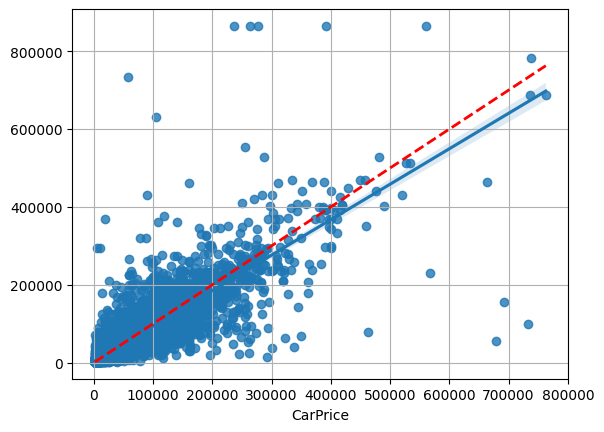

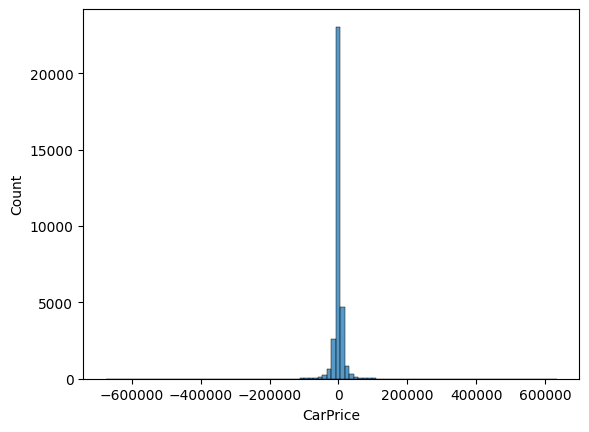

In [5]:
df = read_data('processed_data/preprocessed_car_data.csv',impute_missing=False)
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
decision_tree_model = DecisionTreeRegressor()
if TRAIN_MODELS:
    decision_tree_model.fit(X_train, y_train)
    with open('tree_models/base_decision_tree_model.pkl', 'wb') as fid:
        pickle.dump(decision_tree_model, fid)
else:
    decision_tree_model = GridSearchCV(decision_tree_model,{}, cv=3)
    with open('tree_models/base_decision_tree_model.pkl', 'rb') as fid:
        decision_tree_model = pickle.load(fid)
train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae=train_and_evaluate_model(decision_tree_model, X_train, y_train, X_test, y_test,train_model=False,is_log_transform=False,display_graphs=True)
results.append({
    'model':'Decision Tree Regressor',
    'train_r2':train_r2,
    'train_adj_r2':train_score_adj_r2,
    'train_rmse':train_rmse,
    'train_mae':train_mae,
    'test_r2':test_r2,
    'test_adj_r2':test_score_adj_r2,
    'test_rmse':test_rmse,
    'test_mae':test_mae
})

Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)
Train R2: 0.9082
Train Adjusted R2: 0.908
Train RMSE: 12348.5063
Train MAE: 5177.308
Test R2: 0.8328
Test Adjusted R2: 0.8319
Test RMSE: 16753.8375
Test MAE: 7023.5687


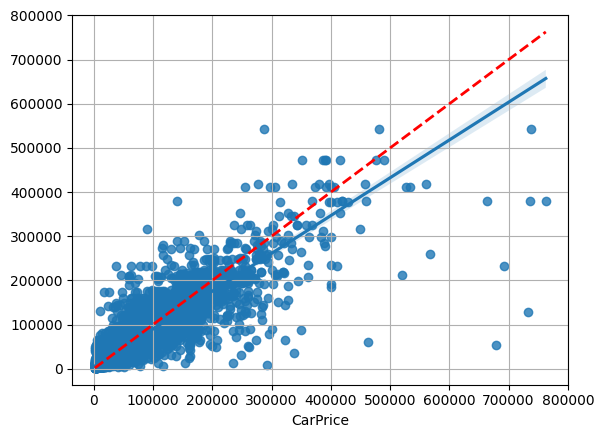

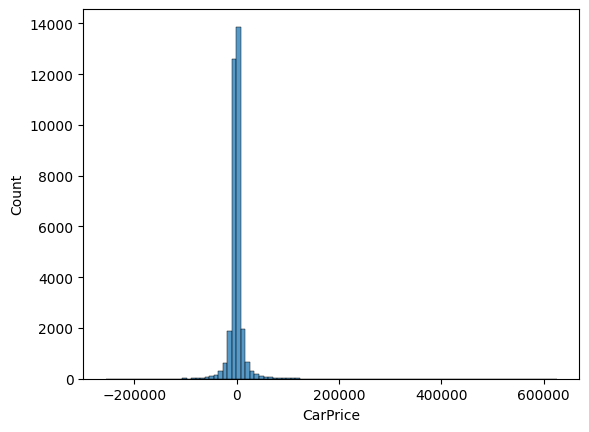

In [6]:
df = read_data('processed_data/preprocessed_car_data.csv',impute_missing=False)
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
decision_tree_model = DecisionTreeRegressor()
if TRAIN_MODELS:
    params = {'criterion':['squared_error', 'friedman_mse', 'poisson'],
            'max_depth':[5,10,20,30,50,None],
            'max_features':[None,'sqrt','log2',10,25,50],
            'min_samples_split':[2,10,50,100,500,1000], 
            'min_samples_leaf':[1,10,50,100,500,1000]}
    decision_tree_model_optimized = GridSearchCV(decision_tree_model, params, cv=3,verbose=2)
    decision_tree_model_optimized.fit(X_train,y_train)
    print("best params:",decision_tree_model_optimized.best_params_)
    print("best score:",decision_tree_model_optimized.best_score_)
    with open('tree_models/base_decision_tree_model_optimized_no_impute.pkl', 'wb') as fid:
        pickle.dump(decision_tree_model_optimized, fid)
else:
    decision_tree_model_optimized = GridSearchCV(decision_tree_model,{}, cv=3)
    with open('tree_models/base_decision_tree_model_optimized_no_impute.pkl', 'rb') as fid:
        decision_tree_model_optimized = pickle.load(fid)

train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae=train_and_evaluate_model(decision_tree_model_optimized, X_train, y_train, X_test, y_test,train_model=False,is_log_transform=False,display_graphs=True)
results.append({
    'model':'Decision Tree Regressor Optimized No Imputed',
    'train_r2':train_r2,
    'train_adj_r2':train_score_adj_r2,
    'train_rmse':train_rmse,
    'train_mae':train_mae,
    'test_r2':test_r2,
    'test_adj_r2':test_score_adj_r2,
    'test_rmse':test_rmse,
    'test_mae':test_mae
})

Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)
Train R2: 0.8854
Train Adjusted R2: 0.8851
Train RMSE: 13798.9668
Train MAE: 5875.6648
Test R2: 0.8271
Test Adjusted R2: 0.8261
Test RMSE: 17037.0801
Test MAE: 7151.234


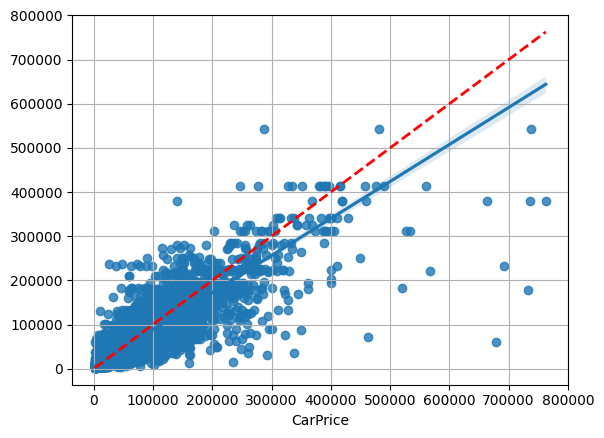

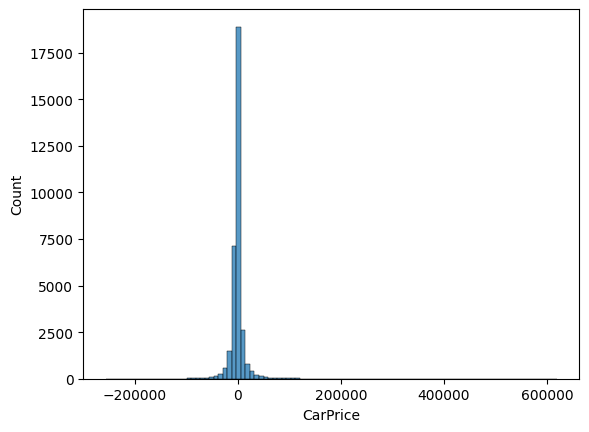

In [32]:
df = read_data('processed_data/preprocessed_car_data.csv',impute_missing=True)
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
decision_tree_model = DecisionTreeRegressor()
if TRAIN_MODELS:
    params = {'criterion':['squared_error', 'friedman_mse', 'poisson'],
            'max_depth':[5,10,20,30,50,None],
            'max_features':[None,'sqrt','log2',10,25,50],
            'min_samples_split':[2,10,50,100,500,1000], 
            'min_samples_leaf':[1,10,50,100,500,1000]}
    decision_tree_model_optimized = GridSearchCV(decision_tree_model, params, cv=3,verbose=2)
    decision_tree_model_optimized.fit(X_train,y_train)
    print("best params:",decision_tree_model_optimized.best_params_)
    print("best score:",decision_tree_model_optimized.best_score_)
    with open('tree_models/base_decision_tree_model_optimized_impute.pkl', 'wb') as fid:
        pickle.dump(decision_tree_model_optimized, fid)
else:
    decision_tree_model_optimized = GridSearchCV(decision_tree_model,{}, cv=3)
    with open('tree_models/base_decision_tree_model_optimized_impute.pkl', 'rb') as fid:
        decision_tree_model_optimized = pickle.load(fid)

train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae=train_and_evaluate_model(decision_tree_model_optimized, X_train, y_train, X_test, y_test,train_model=False,is_log_transform=False,display_graphs=True)
results.append({
    'model':'Decision Tree Regressor Optimized Imputed',
    'train_r2':train_r2,
    'train_adj_r2':train_score_adj_r2,
    'train_rmse':train_rmse,
    'train_mae':train_mae,
    'test_r2':test_r2,
    'test_adj_r2':test_score_adj_r2,
    'test_rmse':test_rmse,
    'test_mae':test_mae
})

Before onehot encoding (110699, 114)
After onehot encoding (110699, 185)
Train R2: 0.9343
Train Adjusted R2: 0.9341
Train RMSE: 10451.5866
Train MAE: 4330.8402
Test R2: 0.8651
Test Adjusted R2: 0.8644
Test RMSE: 15047.2907
Test MAE: 6172.1224


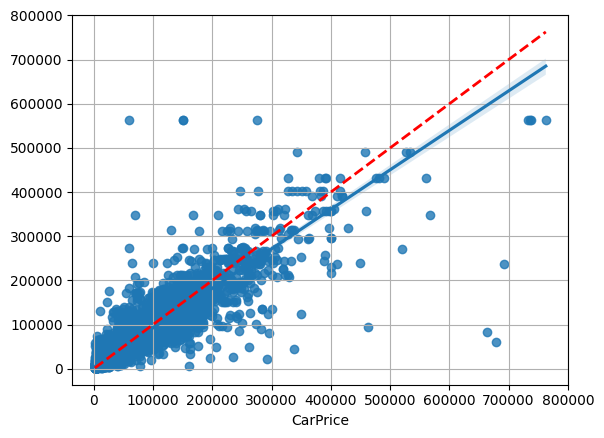

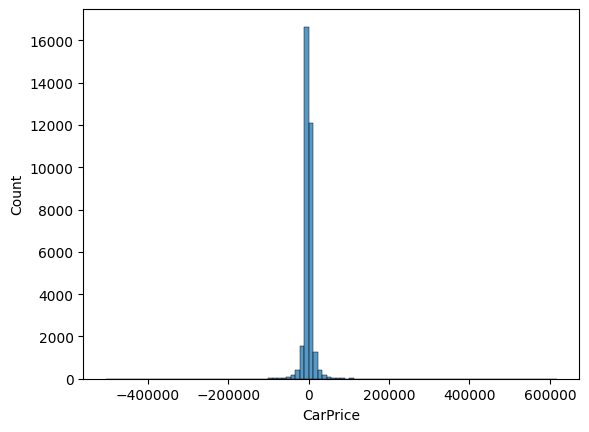

In [33]:
df = read_data('processed_data/preprocessed_car_data.csv',drop_model_column=False,impute_missing=False)
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
decision_tree_model = DecisionTreeRegressor()

X_train['CarPrice'] = y_train
handle_model_column(X_train, X_test)
X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])
if TRAIN_MODELS:
    params = {'criterion':['squared_error', 'friedman_mse', 'poisson'],
            'max_depth':[5,10,20,30,50,None],
            'max_features':[None,'sqrt','log2',10,25,50],
            'min_samples_split':[2,10,50,100,500,1000], 
            'min_samples_leaf':[1,10,50,100,500,1000]}
    decision_tree_model_optimized = GridSearchCV(decision_tree_model, params, cv=3,verbose=2)
    decision_tree_model_optimized.fit(X_train,y_train)
    print("best params:",decision_tree_model_optimized.best_params_)
    print("best score:",decision_tree_model_optimized.best_score_)
    with open('tree_models/base_decision_tree_model_optimized_no_impute_model_column.pkl', 'wb') as fid:
        pickle.dump(decision_tree_model_optimized, fid)
else:
    decision_tree_model_optimized = GridSearchCV(decision_tree_model,{}, cv=3)
    with open('tree_models/base_decision_tree_model_optimized_no_impute_model_column.pkl', 'rb') as fid:
        decision_tree_model_optimized = pickle.load(fid)

train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae=train_and_evaluate_model(decision_tree_model_optimized, X_train, y_train, X_test, y_test,train_model=False,is_log_transform=False,display_graphs=True)
results.append({
    'model':'Decision Tree Regressor Optimized No Imputed With Model Column',
    'train_r2':train_r2,
    'train_adj_r2':train_score_adj_r2,
    'train_rmse':train_rmse,
    'train_mae':train_mae,
    'test_r2':test_r2,
    'test_adj_r2':test_score_adj_r2,
    'test_rmse':test_rmse,
    'test_mae':test_mae
})

# Random Forest skleran

Before onehot encoding (110699, 114)
After onehot encoding (110699, 192)
Train R2: 0.9893
Train Adjusted R2: 0.9893
Train RMSE: 4210.9144
Train MAE: 1708.932
Test R2: 0.9013
Test Adjusted R2: 0.9007
Test RMSE: 12874.6986
Test MAE: 4833.2369


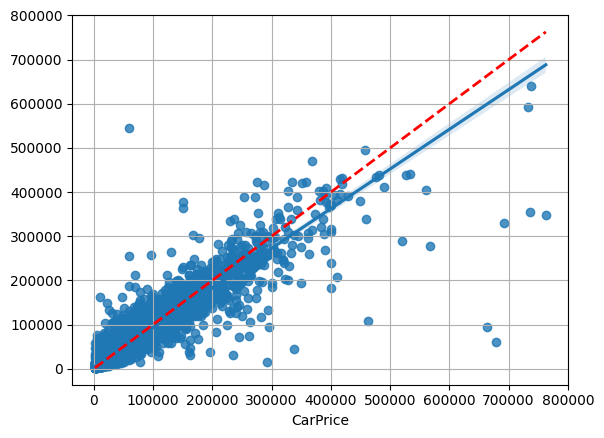

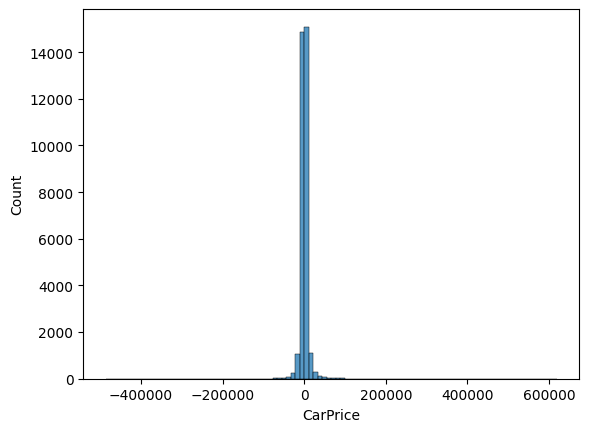

In [34]:
df = read_data('processed_data/preprocessed_car_data.csv',drop_model_column=False,impute_missing=False,dummies_drop_first=False)
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')
random_forest_model = RandomForestRegressor()

X_train['CarPrice'] = y_train
handle_model_column(X_train, X_test)
X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])
if TRAIN_MODELS:
    params = {'n_estimators':[50,100,200,300,500],
        'criterion':['squared_error', 'friedman_mse'],

            }
    random_forest_model_optimized = GridSearchCV(random_forest_model, params, cv=3,verbose=2,n_jobs=-2)
    random_forest_model_optimized.fit(X_train,y_train)
    print("best params:",random_forest_model_optimized.best_params_)
    print("best score:",random_forest_model_optimized.best_score_)
    with open('tree_models/base_random_forest_model_optimized_no_impute_model_column.pkl', 'wb') as fid:
        pickle.dump(random_forest_model_optimized, fid)
else:
    random_forest_model_optimized = GridSearchCV(random_forest_model,{}, cv=3)
    with open('tree_models/base_random_forest_model_optimized_no_impute_model_column.pkl', 'rb') as fid:
        random_forest_model_optimized = pickle.load(fid)
train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae=train_and_evaluate_model(random_forest_model_optimized, X_train, y_train, X_test, y_test,train_model=False,is_log_transform=False,display_graphs=True)
results.append({
    'model':'Random Forest Regressor Optimized No Imputed With Model Column',
    'train_r2':train_r2,
    'train_adj_r2':train_score_adj_r2,
    'train_rmse':train_rmse,
    'train_mae':train_mae,
    'test_r2':test_r2,
    'test_adj_r2':test_score_adj_r2,
    'test_rmse':test_rmse,
    'test_mae':test_mae
})

# XGBoost

In [5]:
import xgboost as xgb

Before onehot encoding (110699, 114)
After onehot encoding (110699, 192)
Train R2: 0.9719
Train Adjusted R2: 0.9718
Train RMSE: 6837.2815
Train MAE: 3963.0533
Test R2: 0.9186
Test Adjusted R2: 0.9181
Test RMSE: 11689.3358
Test MAE: 4865.8369


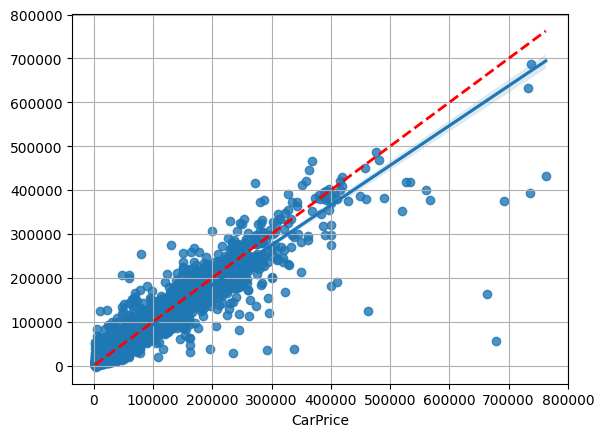

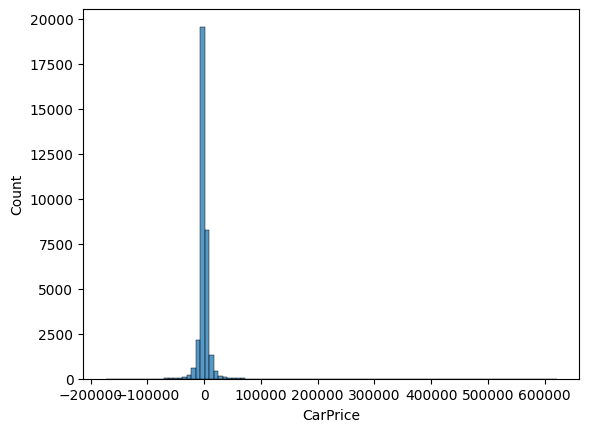

In [36]:
df = read_data('processed_data/preprocessed_car_data.csv',drop_model_column=False,impute_missing=False,dummies_drop_first=False)
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')

X_train['CarPrice'] = y_train
handle_model_column(X_train, X_test)
X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])

#X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=42,shuffle=True)


model = xgb.XGBRegressor(objective='reg:squarederror',
                         random_state=42,early_stopping_rounds=10,
                         n_estimators=1000)
#model.fit(X_train, y_train,verbose=True,eval_set=[(X_test, y_test)])

if TRAIN_MODELS:
    params = {
        'learning_rate':[0.05],
        'gamma':[None],
        'subsample':[None,0.8,1],
        'colsample_bytree':[None,0.8,1],
        'reg_alpha':[2,3,5],
        'reg_lambda':[0.5],

            }
    model = GridSearchCV(model, params, cv=3,verbose=2,n_jobs=-2)
    model.fit(X_train,y_train,eval_set=[(X_test, y_test)])
    print("best params:",model.best_params_)
    print("best score:",model.best_score_)
    with open('tree_models/xgboost.pkl', 'wb') as fid:
        pickle.dump(model, fid)
else:
    model = GridSearchCV(model,{}, cv=3)
    with open('tree_models/xgboost.pkl', 'rb') as fid:
        model = pickle.load(fid)

train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae=train_and_evaluate_model(model, X_train, y_train, X_test, y_test,train_model=False,is_log_transform=False,display_graphs=True)
results.append({
    'model':'XGBoost Regressor No Imputed With Model Column',
    'train_r2':train_r2,
    'train_adj_r2':train_score_adj_r2,
    'train_rmse':train_rmse,
    'train_mae':train_mae,
    'test_r2':test_r2,
    'test_adj_r2':test_score_adj_r2,
    'test_rmse':test_rmse,
    'test_mae':test_mae
})

Before onehot encoding (110699, 119)
After onehot encoding (110699, 226)
Train R2: 0.9827
Train Adjusted R2: 0.9827
Train RMSE: 5360.5391
Train MAE: 3372.0344
Test R2: 0.9324
Test Adjusted R2: 0.932
Test RMSE: 10650.2133
Test MAE: 4568.1326


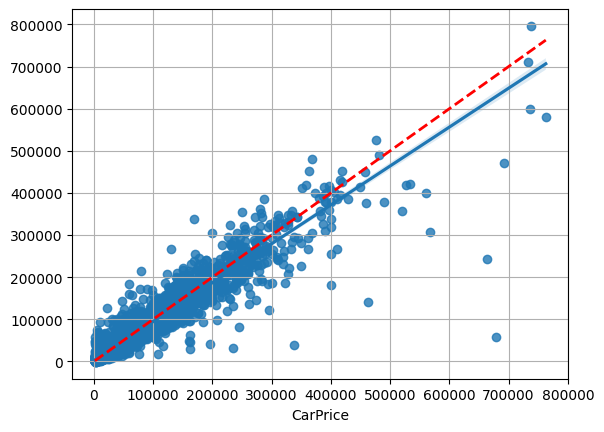

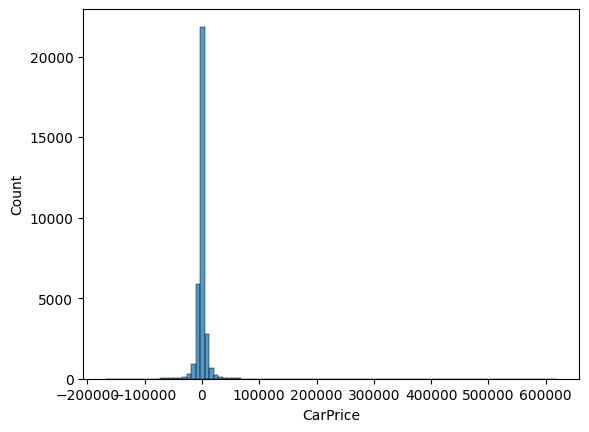

In [ ]:
df = read_data('processed_data/preprocessed_car_data_full_brand.csv',drop_model_column=False,impute_missing=False,dummies_drop_first=False,handle_brand=True)

X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')

X_train['CarPrice'] = y_train
handle_model_column(X_train, X_test)
#handle_model_column(X_train, X_test,column_name='Brand')

X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])
X_train = X_train.drop(columns=['Brand'])
X_test = X_test.drop(columns=['Brand'])
#X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=42,shuffle=True)


model = xgb.XGBRegressor(objective='reg:squarederror',
                         random_state=42,early_stopping_rounds=10,
                         n_estimators=3000)
#model.fit(X_train, y_train,verbose=True,eval_set=[(X_test, y_test)])

if TRAIN_MODELS:
    params = {
        'learning_rate':[0.05],
        'gamma':[None,1],
        'subsample':[None,0.7,0.5],
        'colsample_bytree':[None,0.7,0.5],
        'reg_alpha':[2],
        'reg_lambda':[0.5],

            }
    model = GridSearchCV(model, params, cv=3,verbose=2,n_jobs=-2)
    model.fit(X_train,y_train,eval_set=[(X_test, y_test)])
    print("best params:",model.best_params_)
    print("best score:",model.best_score_)
    with open('tree_models/xgboost_full_model.pkl', 'wb') as fid:
        pickle.dump(model, fid)
else:
    model = GridSearchCV(model,{}, cv=3)
    with open('tree_models/xgboost_full_model.pkl', 'rb') as fid:
        model = pickle.load(fid)

train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae=train_and_evaluate_model(model, X_train, y_train, X_test, y_test,train_model=False,is_log_transform=False,display_graphs=True)
results.append({
    'model':'XGBoost Regressor No Imputed With Model Column full',
    'train_r2':train_r2,
    'train_adj_r2':train_score_adj_r2,
    'train_rmse':train_rmse,
    'train_mae':train_mae,
    'test_r2':test_r2,
    'test_adj_r2':test_score_adj_r2,
    'test_rmse':test_rmse,
    'test_mae':test_mae
})

Before onehot encoding (112477, 130)
After onehot encoding (112477, 262)
Train R2: 0.985
Train Adjusted R2: 0.985
Train RMSE: 6299.1677
Train MAE: 3662.6333
Test R2: 0.9442
Test Adjusted R2: 0.9437
Test RMSE: 11715.9416
Test MAE: 4863.7811


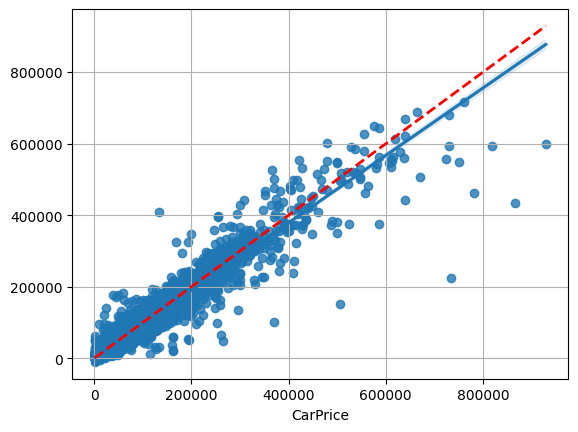

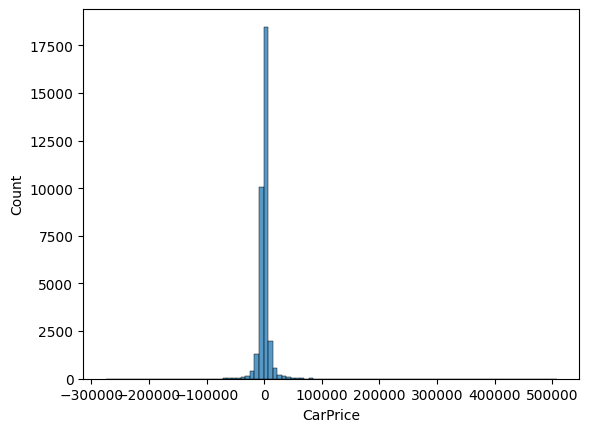

In [38]:
df = read_data('processed_data/preprocessed_car_data_full_brand_with_outliers.csv',drop_model_column=False,impute_missing=False,dummies_drop_first=False,handle_brand=True,model_plus_brand=True,add_new_features=True)

X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice')

X_train['CarPrice'] = y_train
handle_model_column(X_train, X_test)
#handle_model_column(X_train, X_test,column_name='Brand')

X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])
X_train = X_train.drop(columns=['Brand'])
X_test = X_test.drop(columns=['Brand'])
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=42,shuffle=True)


model = xgb.XGBRegressor(objective='reg:squarederror',#objective='reg:squarederror'
                         random_state=42,early_stopping_rounds=10,
                         n_estimators=3000,colsample_bytree=0.5, gamma=0.5, learning_rate=0.05, max_depth=None, reg_alpha=None, reg_lambda=1, subsample=None
                         #booster ='dart'
                         )
#model.fit(X_train, y_train,verbose=True,eval_set=[(X_test, y_test)])

if TRAIN_MODELS:
    params = {
        'learning_rate':[0.05,0.1],
        'gamma':[0.5,1],
        'subsample':[None,0.7,0.5],
        'colsample_bytree':[None,0.7,0.5],
        'reg_alpha':[None,2,3],
        'reg_lambda':[0.5,1],

            }
    model = GridSearchCV(model, params, cv=3,verbose=2,n_jobs=-2)
    model.fit(X_train,y_train,eval_set=[(X_val, y_val)])
    print("best params:",model.best_params_)
    print("best score:",model.best_score_)
    with open('tree_models/xgboost_brand_plus_model.pkl', 'wb') as fid:
        pickle.dump(model, fid)
else:
    model = GridSearchCV(model,{}, cv=3)
    with open('tree_models/xgboost_brand_plus_model.pkl', 'rb') as fid:
        model = pickle.load(fid)

train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae=train_and_evaluate_model(model, X_train, y_train, X_test, y_test,train_model=False,is_log_transform=False,display_graphs=True)
results.append({
    'model':'XGBoost Regressor Model Plus Brand',
    'train_r2':train_r2,
    'train_adj_r2':train_score_adj_r2,
    'train_rmse':train_rmse,
    'train_mae':train_mae,
    'test_r2':test_r2,
    'test_adj_r2':test_score_adj_r2,
    'test_rmse':test_rmse,
    'test_mae':test_mae
})

Before onehot encoding (112477, 130)
After onehot encoding (112477, 262)
[0]	validation_0-rmse:47580.00463
[1]	validation_0-rmse:45578.19791
[2]	validation_0-rmse:43758.25092
[3]	validation_0-rmse:42036.93671
[4]	validation_0-rmse:40568.31243
[5]	validation_0-rmse:38984.32426
[6]	validation_0-rmse:37460.18414
[7]	validation_0-rmse:36323.57295
[8]	validation_0-rmse:34971.17911
[9]	validation_0-rmse:33885.52061
[10]	validation_0-rmse:32849.40757
[11]	validation_0-rmse:31659.46764
[12]	validation_0-rmse:30579.30976
[13]	validation_0-rmse:29634.40344
[14]	validation_0-rmse:28692.78636
[15]	validation_0-rmse:27729.56624
[16]	validation_0-rmse:26952.68449
[17]	validation_0-rmse:26120.01046
[18]	validation_0-rmse:25287.42214
[19]	validation_0-rmse:24511.08009
[20]	validation_0-rmse:23761.39914
[21]	validation_0-rmse:23119.70871
[22]	validation_0-rmse:22577.63901
[23]	validation_0-rmse:22015.55770
[24]	validation_0-rmse:21449.51530
[25]	validation_0-rmse:20968.26835
[26]	validation_0-rmse:2057

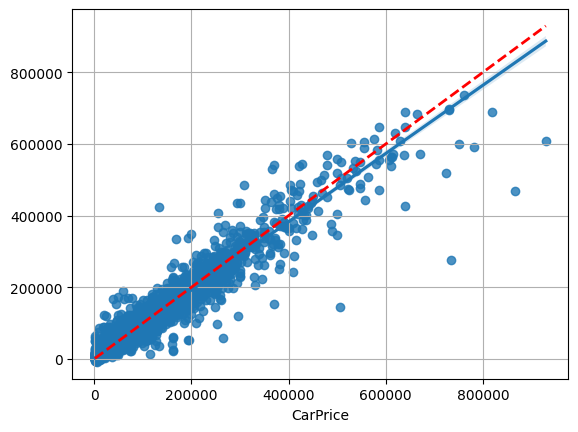

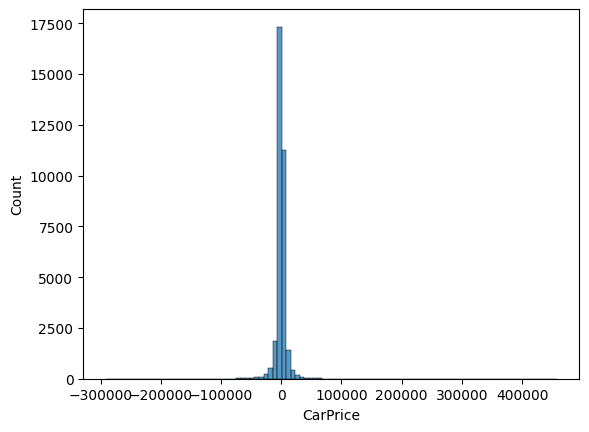

In [39]:

df = read_data('processed_data/preprocessed_car_data_full_brand_with_outliers.csv',drop_model_column=False,impute_missing=False,dummies_drop_first=False,handle_brand=True,model_plus_brand=True,add_new_features=True)

X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice',seed=42)

X_train['CarPrice'] = y_train
handle_model_column(X_train, X_test)
#handle_model_column(X_train, X_test,column_name='Brand')

X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])
X_train = X_train.drop(columns=['Brand'])
X_test = X_test.drop(columns=['Brand'])
final_model = xgb.XGBRegressor(objective='reg:squarederror',#objective='reg:squarederror'
                        random_state=42,early_stopping_rounds=15,
                        n_estimators=3000,colsample_bytree=0.5, gamma=0.5, learning_rate=0.05, reg_alpha=1, reg_lambda=1,
                        #booster ='dart'
                        )
final_model.fit(X_train, y_train,verbose=True,eval_set=[(X_test, y_test)])

with open('tree_models/xgboost_final_with_outliers.pkl', 'wb') as fid:
        pickle.dump(final_model, fid)
final_model.save_model('tree_models/xgboost_final_with_outliers.json')
train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae=train_and_evaluate_model(final_model, X_train, y_train, X_test, y_test,train_model=False,is_log_transform=False,display_graphs=True)
results.append({
    'model':'XGBoost Regressor Final Model With Outliers',
    'train_r2':train_r2,
    'train_adj_r2':train_score_adj_r2,
    'train_rmse':train_rmse,
    'train_mae':train_mae,
    'test_r2':test_r2,
    'test_adj_r2':test_score_adj_r2,
    'test_rmse':test_rmse,
    'test_mae':test_mae
})

In [19]:
df = read_data('processed_data/preprocessed_car_data_full_brand_with_no_outliers.csv',drop_model_column=False,impute_missing=False,dummies_drop_first=False,handle_brand=True,model_plus_brand=True,add_new_features=True)

X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice',seed=42)

X_train['CarPrice'] = y_train
handle_model_column(X_train, X_test)
#handle_model_column(X_train, X_test,column_name='Brand')

X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])
X_train = X_train.drop(columns=['Brand'])
X_test = X_test.drop(columns=['Brand'])
final_model = xgb.XGBRegressor(objective='reg:absoluteerror',#objective='reg:squarederror'
                        random_state=42,early_stopping_rounds=15,
                        n_estimators=3000,colsample_bytree=0.5, gamma=0.5, learning_rate=0.07, reg_alpha=2, reg_lambda=1,
                        #booster ='dart'
                        )
final_model.fit(X_train, y_train,verbose=True,eval_set=[(X_test, y_test)])

with open('tree_models/xgboost_final_no_outliers.pkl', 'wb') as fid:
        pickle.dump(final_model, fid)
final_model.save_model('tree_models/xgboost_final_no_outliers.json')

train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae=train_and_evaluate_model(final_model, X_train, y_train, X_test, y_test,train_model=False,is_log_transform=False,display_graphs=True)
results.append({
    'model':'XGBoost Regressor Final Model No Outliers',
    'train_r2':train_r2,
    'train_adj_r2':train_score_adj_r2,
    'train_rmse':train_rmse,
    'train_mae':train_mae,
    'test_r2':test_r2,
    'test_adj_r2':test_score_adj_r2,
    'test_rmse':test_rmse,
    'test_mae':test_mae
})

Before onehot encoding (110699, 130)
After onehot encoding (110699, 261)
[0]	validation_0-mae:21436.04531
[1]	validation_0-mae:20352.64039
[2]	validation_0-mae:19385.25450
[3]	validation_0-mae:18489.54978
[4]	validation_0-mae:17639.80720
[5]	validation_0-mae:16808.66779
[6]	validation_0-mae:16065.47477
[7]	validation_0-mae:15371.93196
[8]	validation_0-mae:14753.12572
[9]	validation_0-mae:14146.83624
[10]	validation_0-mae:13691.48490
[11]	validation_0-mae:13145.23102
[12]	validation_0-mae:12632.92218
[13]	validation_0-mae:12203.97657
[14]	validation_0-mae:11750.89038
[15]	validation_0-mae:11331.20588
[16]	validation_0-mae:10943.72300
[17]	validation_0-mae:10588.19774
[18]	validation_0-mae:10274.58757
[19]	validation_0-mae:9976.72496
[20]	validation_0-mae:9725.89511
[21]	validation_0-mae:9467.75013
[22]	validation_0-mae:9237.48620
[23]	validation_0-mae:8987.81566
[24]	validation_0-mae:8770.31468
[25]	validation_0-mae:8551.18243
[26]	validation_0-mae:8377.67833
[27]	validation_0-mae:8219.

KeyboardInterrupt: 

Before onehot encoding (112477, 132)
After onehot encoding (112477, 264)
Final training shape: (78733, 266)
[0]	validation_0-mae:24028.13368
[1]	validation_0-mae:23243.03998
[2]	validation_0-mae:22489.25163
[3]	validation_0-mae:21735.56880
[4]	validation_0-mae:21060.11584
[5]	validation_0-mae:20419.60590
[6]	validation_0-mae:19778.81474
[7]	validation_0-mae:19250.04050
[8]	validation_0-mae:18644.93383
[9]	validation_0-mae:18090.26875
[10]	validation_0-mae:17597.33851
[11]	validation_0-mae:17099.95459
[12]	validation_0-mae:16630.27147
[13]	validation_0-mae:16126.06766
[14]	validation_0-mae:15701.87185
[15]	validation_0-mae:15309.50431
[16]	validation_0-mae:14911.78344
[17]	validation_0-mae:14522.72243
[18]	validation_0-mae:14140.44643
[19]	validation_0-mae:13791.72288
[20]	validation_0-mae:13435.69581
[21]	validation_0-mae:13096.29771
[22]	validation_0-mae:12831.01163
[23]	validation_0-mae:12530.51602
[24]	validation_0-mae:12224.50575
[25]	validation_0-mae:11923.22312
[26]	validation_0-

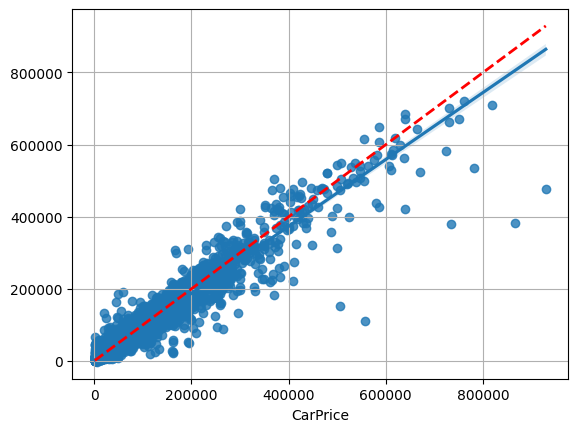

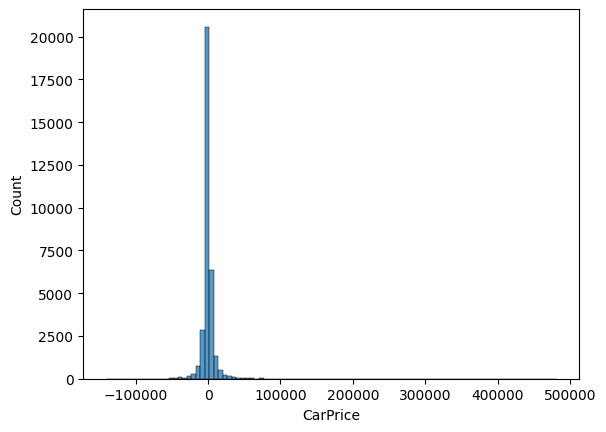

In [20]:
df = read_data('processed_data/preprocessed_car_data_full_brand_with_outliers_description.csv',drop_model_column=False,impute_missing=False,dummies_drop_first=False,handle_brand=True,model_plus_brand=True,add_new_features=True,drop_condition_col=True,keywords=True)


X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice',seed=42)

X_train['CarPrice'] = y_train
handle_model_column(X_train, X_test)
#handle_model_column(X_train, X_test,column_name='Brand')

X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])
X_train = X_train.drop(columns=['Brand'])
X_test = X_test.drop(columns=['Brand'])
final_model = xgb.XGBRegressor(objective='reg:absoluteerror',#objective='reg:squarederror'
                        random_state=42,early_stopping_rounds=100,
                        n_estimators=7000,colsample_bytree=0.5, gamma=0.5, learning_rate=0.05, reg_alpha=1, reg_lambda=1,
                        #booster ='dart'
                        )

print("Final training shape:",X_train.shape)
final_model.fit(X_train, y_train,verbose=True,eval_set=[(X_test, y_test)])


train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae=train_and_evaluate_model(final_model, X_train, y_train, X_test, y_test,train_model=False,is_log_transform=False,display_graphs=True)
results.append({
    'model':'XGBoost Regressor Final Model With Outliers and keywords columns',
    'train_r2':train_r2,
    'train_adj_r2':train_score_adj_r2,
    'train_rmse':train_rmse,
    'train_mae':train_mae,
    'test_r2':test_r2,
    'test_adj_r2':test_score_adj_r2,
    'test_rmse':test_rmse,
    'test_mae':test_mae
})

In [42]:
#df = pd.DataFrame(results)
#df.to_csv('tree_models/tree_model_results.csv',index=False)
#display(df)

In [1]:

final_model = xgb.XGBRegressor(objective='reg:squarederror',#objective='reg:squarederror'
                         random_state=42,early_stopping_rounds=15,
                         n_estimators=3000,colsample_bytree=0.5, gamma=0.5, learning_rate=0.06, reg_alpha=1.8, reg_lambda=1,
                         #booster ='dart'
                         )

with open('tree_models/xgboost_final_with_outliers.pkl', 'rb') as fid:
    final_model = pickle.load(fid)

res,aggregated=plot_importance(final_model,num_features=20)
features_ordered=res['feature'].tolist()
aggregated_features = aggregated.index.tolist()

NameError: name 'xgb' is not defined

Before onehot encoding (112477, 130)
After onehot encoding (112477, 262)
Final training shape: (78733, 267)
[0]	validation_0-mae:23994.59459
[1]	validation_0-mae:23227.55790
[2]	validation_0-mae:22474.54086
[3]	validation_0-mae:21742.92669
[4]	validation_0-mae:21020.19758
[5]	validation_0-mae:20379.86639
[6]	validation_0-mae:19722.90782
[7]	validation_0-mae:19122.18867
[8]	validation_0-mae:18536.13396
[9]	validation_0-mae:17959.31099
[10]	validation_0-mae:17524.11627
[11]	validation_0-mae:17069.24921
[12]	validation_0-mae:16622.87010
[13]	validation_0-mae:16157.73336
[14]	validation_0-mae:15721.62940
[15]	validation_0-mae:15264.99436
[16]	validation_0-mae:14839.86521
[17]	validation_0-mae:14409.50097
[18]	validation_0-mae:14082.61347
[19]	validation_0-mae:13719.45554
[20]	validation_0-mae:13338.03245
[21]	validation_0-mae:12983.65467
[22]	validation_0-mae:12705.09073
[23]	validation_0-mae:12389.85685
[24]	validation_0-mae:12140.73740
[25]	validation_0-mae:11850.23917
[26]	validation_0-

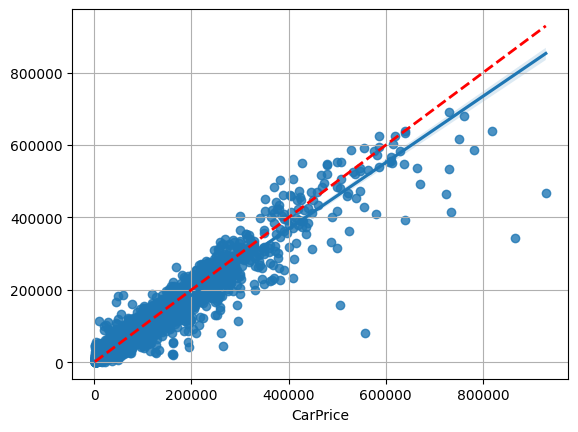

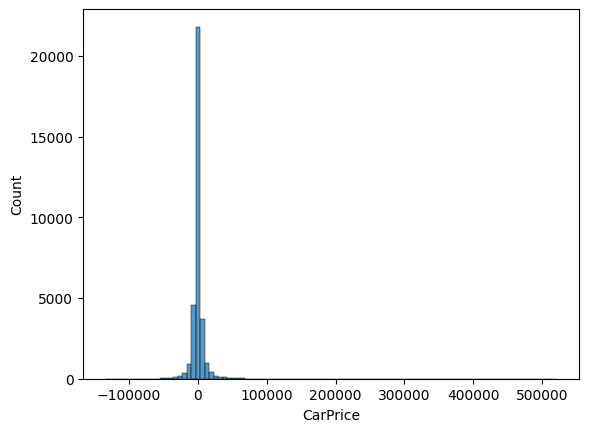

In [9]:
df = read_data('processed_data/preprocessed_car_data_full_brand_with_outliers.csv',drop_model_column=False,impute_missing=False,dummies_drop_first=False,handle_brand=True,model_plus_brand=True,add_new_features=True,drop_condition_col=True)


X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice',seed=42)

X_train['CarPrice'] = y_train
handle_model_column(X_train, X_test)
handle_model_column(X_train, X_test,column_name='Brand')

X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])
X_train = X_train.drop(columns=['Brand'])
X_test = X_test.drop(columns=['Brand'])
final_model = xgb.XGBRegressor(objective='reg:absoluteerror',#objective='reg:squarederror'
                        random_state=42,early_stopping_rounds=100,
                        n_estimators=5000,colsample_bytree=0.5, gamma=0.5, learning_rate=0.05, reg_alpha=1, reg_lambda=1,
                        #booster ='dart'
                        )

#X_train=X_train.drop(columns=features_ordered[-50:])
#X_test=X_test.drop(columns=features_ordered[-50:])
print("Final training shape:",X_train.shape)
final_model.fit(X_train, y_train,verbose=True,eval_set=[(X_test, y_test)])


train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae=train_and_evaluate_model(final_model, X_train, y_train, X_test, y_test,train_model=False,is_log_transform=False,display_graphs=True)
results.append({
    'model':'XGBoost Regressor Final Model With Outliers',
    'train_r2':train_r2,
    'train_adj_r2':train_score_adj_r2,
    'train_rmse':train_rmse,
    'train_mae':train_mae,
    'test_r2':test_r2,
    'test_adj_r2':test_score_adj_r2,
    'test_rmse':test_rmse,
    'test_mae':test_mae
})

In [21]:
res = final_model.predict(X_test)
abs(res-y_test).median()

np.float64(1971.7451171875)

In [22]:
y_test.median()

np.float64(18888.0)

In [46]:
results

[{'model': 'Decision Tree Regressor',
  'train_r2': 0.999215332407766,
  'train_adj_r2': 0.9992134647316178,
  'train_rmse': 1141.9312874756,
  'train_mae': 45.33291028404032,
  'test_r2': 0.767809300001577,
  'test_adj_r2': 0.7665156409917447,
  'test_rmse': 19744.037889069125,
  'test_mae': 7692.916288216402},
 {'model': 'Decision Tree Regressor Optimized No Imputed',
  'train_r2': 0.9082439669087381,
  'train_adj_r2': 0.9080255679890341,
  'train_rmse': 12348.506335156884,
  'train_mae': 5177.307954871571,
  'test_r2': 0.8328133991668122,
  'test_adj_r2': 0.8318819128820791,
  'test_rmse': 16753.83752149527,
  'test_mae': 7023.568695158919},
 {'model': 'Decision Tree Regressor Optimized Imputed',
  'train_r2': 0.8854226137501754,
  'train_adj_r2': 0.8851498951447996,
  'train_rmse': 13798.96679652073,
  'train_mae': 5875.664838536951,
  'test_r2': 0.8271126569552828,
  'test_adj_r2': 0.8261494087760177,
  'test_rmse': 17037.080105419067,
  'test_mae': 7151.234019997147},
 {'model': 

In [50]:
df = pd.DataFrame(results)
display(df[['model','test_r2','test_mae']])

,model,test_r2,test_mae
0,Decision Tree Regressor,0.767809,7692.916288
1,Decision Tree Regressor Optimized No Imputed,0.832813,7023.568695
2,Decision Tree Regressor Optimized Imputed,0.827113,7151.234020
3,Decision Tree Regressor Optimized No Imputed W...,0.865138,6172.122362
4,Random Forest Regressor Optimized No Imputed W...,0.901270,4833.236946
5,XGBoost Regressor No Imputed With Model Column,0.918613,4865.836899
6,XGBoost Regressor No Imputed With Model Column...,0.932440,4568.132575
7,XGBoost Regressor Model Plus Brand,0.944189,4863.781069
8,XGBoost Regressor Final Model With Outliers,0.950415,4623.219142
9,XGBoost Regressor Final Model No Outliers,0.935102,4353.980896


In [55]:
df.to_csv('tree_models/tree_model_results.csv')